# Pneumonia Detection with CNN

In this project, CNN models will be built as an attempt to predict whether a chest x-ray shows evidence of pneumonia or not. The images were obtained from [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import glob
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

%matplotlib inline

## Extracting the Set

In [2]:
class_dict = {0:'Normal',1:'Pneumonia'}

In [3]:
def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows 
    nC0 = len(im[0])  # source number of columns 
    return np.asarray([[ im[int(nR0 * r / nR)][int(nC0 * c / nC)] for c in range(nC)] for r in range(nR)])

In [4]:
def load_data(train=True,normal=True):
    
    # Complete the string for path
    if train:
        st1 = 'train'
    else:
        st1 = 'test'
    
    if normal:
        st2 = 'NORMAL'
    else:
        st2 = 'PNEUMONIA'
    
    path = "../../data/chest_xray/{}/{}/*.jpeg".format(st1,st2)
    
    # Import the data and resize it
    lst = []
    for file in glob.glob(path):
        img = plt.imread(file)
        img = scale(img, 224, 224)
        
        if img.shape!=(224,224):
            img = np.mean(img, axis=2)
            
        img = np.array(img, dtype=np.float64) / img.max()
        img = np.expand_dims(img, axis=-1)
        lst.append(img)
        
    # Reshape data
    lst = np.asarray(lst)
    
    # Generate output
    output = []
    for i in range(len(lst)):
        output.append(int(not normal))
    output = np.asarray(output)
    return lst, output

In [5]:
def join_n_shuffle(train=True):
    
    data_n , res_n = load_data(train=train)
    data_p , res_p = load_data(train=train, normal=False)
    
    data_joined = np.concatenate((data_n, data_p), axis=0)
    res_joined = np.concatenate((res_n, res_p), axis=0)
    
    np.random.seed(42)
    np.random.shuffle(data_joined)
    np.random.shuffle(res_joined)
    
    return data_joined, res_joined

Training and Testing Splits

In [6]:
X_train, y_train = join_n_shuffle()

In [7]:
X_test, y_test = join_n_shuffle(False)

In [8]:
def show_sample(n=-1):
    
    if n==-1:
        n=np.random.randint(len(y_train)-1)
    
    print('Sample {}: {}'.format(n,class_dict[y_train[n]]))
    plt.imshow(X_train[n],cmap='gray')
    plt.axis('off')

Sample 3190: Normal


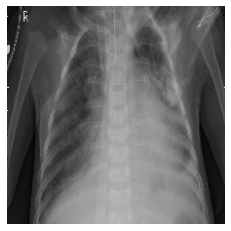

In [35]:
show_sample()

## Features of Data

In [8]:
print('Shape X_train: ', X_train.shape)
print('Shape y_train: ', y_train.shape)
print('Shape X_test: ', X_test.shape)
print('Shape y_test: ', y_test.shape)

Shape X_train:  (5216, 224, 224, 1)
Shape y_train:  (5216,)
Shape X_test:  (624, 224, 224, 1)
Shape y_test:  (624,)


Counts

In [18]:
counts = pd.concat(
    [pd.DataFrame(y_train).replace(class_dict).value_counts(normalize=False).to_frame(name= 'Train'),
     pd.DataFrame(y_test).replace(class_dict).value_counts(normalize=False).to_frame(name= 'Test')], axis=1).T
counts

,Pneumonia,Normal
Train,3875,1341
Test,390,234


<function matplotlib.pyplot.show(close=None, block=None)>

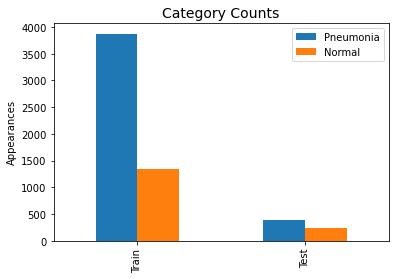

In [20]:
counts.plot(kind='bar')
plt.xlabel(None)
plt.legend(['Pneumonia', 'Normal'])
plt.title('Category Counts', fontsize=14)
plt.ylabel('Appearances')
plt.show

Percentage

In [13]:
per = pd.concat(
    [pd.DataFrame(y_train).replace(class_dict).value_counts(normalize=True).to_frame(name= 'Train'),
     pd.DataFrame(y_test).replace(class_dict).value_counts(normalize=True).to_frame(name= 'Test')], axis=1).T
per

,Pneumonia,Normal
Train,0.742906,0.257094
Test,0.625000,0.375000


<function matplotlib.pyplot.show(close=None, block=None)>

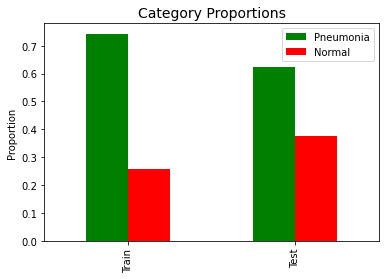

In [21]:
per.plot(kind='bar',color=['g','r'])
plt.xlabel(None)
plt.title('Category Proportions', fontsize=14)
plt.legend(['Pneumonia', 'Normal'])
plt.ylabel('Proportion')
plt.show

### Undersampling the Training Set

In [9]:
y_train_u = y_train
X_train_u = X_train
num_del = np.where(y_train_u==1)[0].shape[0]-np.where(y_train_u==0)[0].shape[0]
random.seed(10)
samples2del = random.sample(set(np.where(y_train_u==1)[0]),num_del)
y_train_u = np.delete(y_train_u, samples2del)
X_train_u = np.delete(X_train_u, samples2del, axis=0)

In [10]:
print('Shape X_train_u: ', X_train_u.shape)
print('Shape y_train_u: ', y_train_u.shape)

Shape X_train_u:  (2682, 224, 224, 1)
Shape y_train_u:  (2682,)


In [94]:
new_counts = pd.concat(
    [pd.DataFrame(y_train_u).replace(class_dict).value_counts(normalize=False).to_frame(name= 'New Train'),
     pd.DataFrame(y_test).replace(class_dict).value_counts(normalize=False).to_frame(name= 'Test')], axis=1).T
new_counts

,Pneumonia,Normal
New Train,1341,1341
Test,390,234


<function matplotlib.pyplot.show(close=None, block=None)>

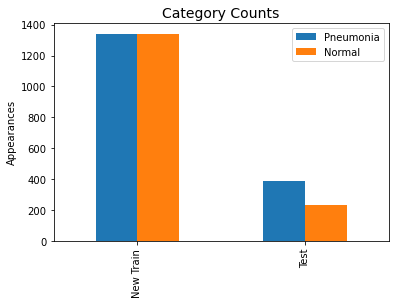

In [95]:
new_counts.plot(kind='bar')
plt.xlabel(None)
plt.legend(['Pneumonia', 'Normal'])
plt.title('Category Counts', fontsize=14)
plt.ylabel('Appearances')
plt.show

In [49]:
new_per = pd.concat(
    [pd.DataFrame(y_train_u).replace(class_dict).value_counts(normalize=True).to_frame(name= 'New Train'),
     pd.DataFrame(y_test).replace(class_dict).value_counts(normalize=True).to_frame(name= 'Test')], axis=1).T
new_per

,Pneumonia,Normal
New Train,0.500,0.500
Test,0.625,0.375


<function matplotlib.pyplot.show(close=None, block=None)>

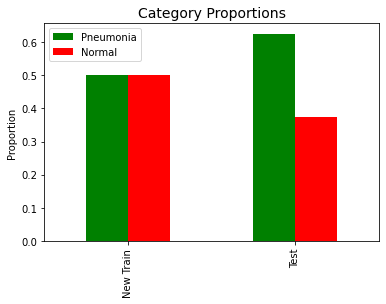

In [99]:
new_per.plot(kind='bar',color=['g','r'])
plt.xlabel(None)
plt.title('Category Proportions', fontsize=14)
plt.legend(['Pneumonia', 'Normal'])
plt.ylabel('Proportion')
plt.show

## Model

In [11]:
y_train_t = keras.utils.to_categorical(y_train_u, 2)
y_test_t = keras.utils.to_categorical(y_test, 2)

### Model without Dropout

In [59]:
model1 = Sequential()

# 1. Two Convolutional layers of 16 3x3 filters with a stride of 1 and a ReLU activation 
model1.add(Conv2D(filters=16, kernel_size=(3, 3), strides = (1,1), padding='same',
                 input_shape=X_train_u.shape[1:], activation='relu'))
model1.add(Conv2D(filters=16, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 2. A Maxpooling layer to reduce size half
model1.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Two Convolutional layers of 32 3x3 filters with a stride of 1 and a ReLU activation
model1.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))
model1.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 4. A Maxpooling layer to reduce size by a fourth
model1.add(MaxPooling2D(pool_size=(4, 4)))

# 3. Two Convolutional layers of 64 3x3 filters with a stride of 1 and a ReLU activation
model1.add(Conv2D(filters=64, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))
model1.add(Conv2D(filters=64, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 4. A Maxpooling layer to reduce size by a fourth
model1.add(MaxPooling2D(pool_size=(4, 4)))

# 11. A flattening layer
model1.add(Flatten())

# 12. A fully connected layer with ReLU activation
model1.add(Dense(units=50, activation='relu'))

# 13. A fully connected layer with Softmax activation
model1.add(Dense(units=2, activation='softmax'))

model1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 224, 224, 16)      160       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 28, 28, 64)      

In [60]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001)

# Let's train the model using RMSprop
model1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

for i in range(1,51):
    model1.fit(X_train_u, y_train_t,
                  batch_size=batch_size,
                  epochs=1,
                  validation_data=(X_test, y_test_t), 
                  shuffle=True, verbose=0)
    acc = model1.evaluate(X_test, y_test_t, verbose=0)[1]
    
    if acc>0.6 and acc!=new_per.loc['Test'].max():
        print('Number of epochs: {}'.format(i))
        break
        
    if i%10==0:
        print('{} epochs completed'.format(i))

Number of epochs: 4


### Model with Dropout

In [63]:
model2 = Sequential()

# 1. Two Convolutional layers of 16 3x3 filters with a stride of 1 and a ReLU activation 
model2.add(Conv2D(filters=16, kernel_size=(3, 3), strides = (1,1), padding='same',
                 input_shape=X_train_u.shape[1:], activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 2. A Maxpooling layer to reduce size half with dropout
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

# 3. Two Convolutional layers of 32 3x3 filters with a stride of 1 and a ReLU activation
model2.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 4. A Maxpooling layer to reduce size by a fourth with dropout
model2.add(MaxPooling2D(pool_size=(4, 4)))
model2.add(Dropout(0.25))

# 3. Two Convolutional layers of 64 3x3 filters with a stride of 1 and a ReLU activation
model2.add(Conv2D(filters=64, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 4. A Maxpooling layer to reduce size by a fourth with dropout
model2.add(MaxPooling2D(pool_size=(4, 4)))
model2.add(Dropout(0.25))

# 11. A flattening layer
model2.add(Flatten())

# 12. A fully connected layer with ReLU activation with dropout
model2.add(Dense(units=50, activation='relu'))
model2.add(Dropout(0.5))

# 13. A fully connected layer with Softmax activation
model2.add(Dense(units=2, activation='softmax'))

model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 224, 224, 16)      160       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 28, 28, 32)      

In [65]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001)

# Let's train the model using RMSprop
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model2.fit(X_train_u, y_train_t,
                  batch_size=batch_size,
                  epochs=10,
                  validation_data=(X_test, y_test_t), 
                  shuffle=True)

Train on 2682 samples, validate on 624 samples
Epoch 1/10
2682/2682 [==============================] - 307s 114ms/sample - loss: 0.6943 - accuracy: 0.5112 - val_loss: 0.6938 - val_accuracy: 0.4119
Epoch 2/10
2682/2682 [==============================] - 305s 114ms/sample - loss: 0.6953 - accuracy: 0.4978 - val_loss: 0.6921 - val_accuracy: 0.6202
Epoch 3/10
2682/2682 [==============================] - 299s 112ms/sample - loss: 0.6938 - accuracy: 0.4933 - val_loss: 0.6947 - val_accuracy: 0.3750
Epoch 4/10
2682/2682 [==============================] - 303s 113ms/sample - loss: 0.6934 - accuracy: 0.4918 - val_loss: 0.6936 - val_accuracy: 0.4247
Epoch 5/10
2682/2682 [==============================] - 312s 116ms/sample - loss: 0.6936 - accuracy: 0.4996 - val_loss: 0.6925 - val_accuracy: 0.6170
Epoch 6/10
2682/2682 [==============================] - 316s 118ms/sample - loss: 0.6932 - accuracy: 0.5067 - val_loss: 0.6934 - val_accuracy: 0.4103
Epoch 7/10
2682/2682 [==============================]

In [68]:
model3 = Sequential()

# 1. Two Convolutional layers of 16 3x3 filters with a stride of 1 and a ReLU activation 
model3.add(Conv2D(filters=16, kernel_size=(3, 3), strides = (1,1), padding='same',
                 input_shape=X_train_u.shape[1:], activation='relu'))
model3.add(Conv2D(filters=16, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 2. A Maxpooling layer to reduce size half with dropout
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# 3. Two Convolutional layers of 32 3x3 filters with a stride of 1 and a ReLU activation
model3.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 4. A Maxpooling layer to reduce size by a fourth with dropout
model3.add(MaxPooling2D(pool_size=(4, 4)))
model3.add(Dropout(0.25))

# 3. Two Convolutional layers of 64 3x3 filters with a stride of 1 and a ReLU activation
model3.add(Conv2D(filters=64, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), strides = (1,1), padding='same', activation='relu'))

# 4. A Maxpooling layer to reduce size by a fourth with dropout
model3.add(MaxPooling2D(pool_size=(4, 4)))
model3.add(Dropout(0.25))

# 11. A flattening layer
model3.add(Flatten())

# 12. A fully connected layer with ReLU activation with dropout
model3.add(Dense(units=50, activation='relu'))
model3.add(Dropout(0.5))

# 13. A fully connected layer with Softmax activation
model3.add(Dense(units=2, activation='softmax'))

model3.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 224, 224, 16)      160       
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 28, 28, 32)      

In [69]:
batch_size = 32

# Let's train the model using RMSprop
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.fit(X_train_u, y_train_t,
                  batch_size=batch_size,
                  epochs=10,
                  validation_data=(X_test, y_test_t), 
                  shuffle=True)

Train on 2682 samples, validate on 624 samples
Epoch 1/10
2682/2682 [==============================] - 321s 120ms/sample - loss: 0.6944 - accuracy: 0.4896 - val_loss: 0.6914 - val_accuracy: 0.6250
Epoch 2/10
2682/2682 [==============================] - 300s 112ms/sample - loss: 0.6933 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.3750
Epoch 3/10
2682/2682 [==============================] - 303s 113ms/sample - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5994
Epoch 4/10
2682/2682 [==============================] - 300s 112ms/sample - loss: 0.6933 - accuracy: 0.5145 - val_loss: 0.6962 - val_accuracy: 0.3750
Epoch 5/10
2682/2682 [==============================] - 300s 112ms/sample - loss: 0.6933 - accuracy: 0.4955 - val_loss: 0.6912 - val_accuracy: 0.6250
Epoch 6/10
2682/2682 [==============================] - 300s 112ms/sample - loss: 0.6941 - accuracy: 0.5048 - val_loss: 0.6851 - val_accuracy: 0.6250
Epoch 7/10
2682/2682 [==============================]

In [72]:
for i in range(1,51):
    model3.fit(X_train_u, y_train_t,
                  batch_size=batch_size,
                  epochs=1,
                  validation_data=(X_test, y_test_t), 
                  shuffle=True, verbose=0)
    acc = model3.evaluate(X_test, y_test_t, verbose=0)[1]
    
    if acc>0.6 and acc!=new_per.loc['Test'].max():
        print('Number of epochs: {}'.format(i))
        break
        
    if i%10==0:
        print('{} epochs completed'.format(i))

Number of epochs: 4


## Error

In [61]:
error_lbl=['Accuracy','Precision','Recall','F1']

def error_lst(model):
    y_pred = model.predict_classes(X_test)
    error = [accuracy_score(y_test,y_pred),precision_score(y_test,y_pred),
            recall_score(y_test,y_pred), f1_score(y_test,y_pred)]
    
    return error

def c_matrix(model,title):
    y_pred = model.predict_classes(X_test)

    cm = confusion_matrix(y_test, y_pred)
    _, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})

    #labels = ['Non-Fraudulent', 'Fraudulent']
    #ax.set_xticklabels(labels, fontsize=25);
    #ax.set_yticklabels(labels[::-1], fontsize=25);
    ax.set_ylabel('True Label', fontsize=30);
    ax.set_xlabel('Predicted Label', fontsize=30)
    ax.set_title(title, fontsize=30)
    

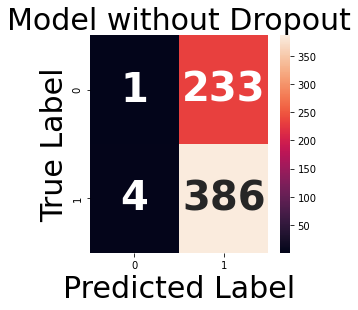

In [62]:
m1_err=error_lst(model1)
c_matrix(model1,'Model without Dropout')

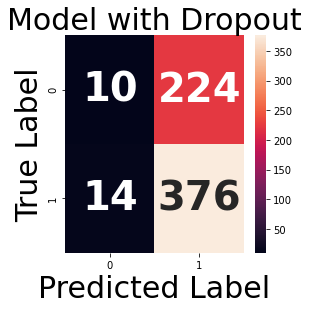

In [67]:
m2_err=error_lst(model2)
c_matrix(model2,'Model with Dropout')

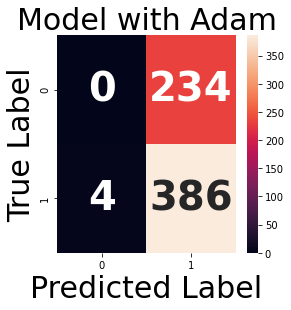

In [73]:
m3_err=error_lst(model3)
c_matrix(model3,'Model with Adam')

In [74]:
error_vals = [m1_err, m2_err,m3_err]
models = ['Model 1 (RMSprop)','Model 2 (RMSprop with Dropout)', 'Model 3 (Adam with Dropout)']
error_df = pd.DataFrame(error_vals, index=models, columns=error_lbl)
error_df

,Accuracy,Precision,Recall,F1
Model 1 (RMSprop),0.620192,0.623586,0.989744,0.765114
Model 2 (RMSprop with Dropout),0.618590,0.626667,0.964103,0.759596
Model 3 (Adam with Dropout),0.618590,0.622581,0.989744,0.764356
